In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D ,LSTM ,RepeatVector,TimeDistributed
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

In [55]:
df=pd.read_csv('OVS.csv')
df.head(5)

,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,172.17.0.2-200.175.2.130-80-48856-6,200.175.2.130,48856,172.17.0.2,80,6,12/1/2020 1:14,4045,2,5,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BFA
1,172.17.0.2-200.175.2.130-80-48856-6,200.175.2.130,48856,172.17.0.2,80,6,12/1/2020 1:14,284,1,1,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BFA
2,172.17.0.2-200.175.2.130-80-48858-6,200.175.2.130,48858,172.17.0.2,80,6,12/1/2020 1:14,4302,2,5,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BFA
3,172.17.0.2-200.175.2.130-80-48858-6,200.175.2.130,48858,172.17.0.2,80,6,12/1/2020 1:14,83,1,1,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BFA
4,172.17.0.2-200.175.2.130-80-48860-6,200.175.2.130,48860,172.17.0.2,80,6,12/1/2020 1:14,3760,2,5,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BFA


In [56]:
df.drop(['Flow ID', 'Src IP' ,'Dst IP' ,'Timestamp','Src Port','Dst Port','Protocol'], inplace=True,axis = 1)
df.shape
df = df.dropna('columns')# drop columns with NaN
pmap = {'Normal':0,'Probe ':1,'DDoS':1,'DoS':1,'BFA':1,'Web-Attack':1,'BOTNET':1,'U2R':1,'DDoS':1}
df['Label'] = df['Label'].map(pmap)

In [57]:
df['Label'].value_counts()

1.0    53937
Name: Label, dtype: int64

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score

In [59]:
Y = df[['Label']]
X = df.drop(['Label',], axis=1)

sc = MinMaxScaler(feature_range = (0, 1))
X = sc.fit_transform(X)

In [60]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape)
print(Y_train.shape, Y_test.shape)

(97105, 76) (41617, 76)
(97105, 1) (41617, 1)


In [61]:
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Test data shape:", X_test.shape)

Training data shape: (97105, 1, 76)
Test data shape: (41617, 1, 76)


In [62]:
import tensorflow as tf
#model=tf.saved_model.load("my_model.h5")
from tensorflow import keras
new_model = tf.keras.models.load_model('my_model.h5')

In [63]:
print(X_test.shape)
#print(X_train_pred.shape)

(41617, 1, 76)
(103167, 76, 76)


In [64]:
X_train_pred = new_model.predict(X_test, verbose=0)
train_mae_loss = np.mean(np.abs(X_train_pred - X_test), axis=1)


In [65]:
print(train_mae_loss)

[[0.01870551 0.00028811 0.00188162 ... 0.00188903 0.01045193 0.01514281]
 [0.00366365 0.00069445 0.0020974  ... 0.02888118 0.02275633 0.00764042]
 [0.03507817 0.00095312 0.00089827 ... 0.0081519  0.04409654 0.03758816]
 ...
 [0.00568648 0.00053488 0.00060933 ... 0.00080381 0.00195239 0.00404584]
 [0.00366365 0.00069445 0.0020974  ... 0.02888118 0.02275633 0.00764042]
 [0.00568648 0.00053488 0.00060933 ... 0.00080381 0.00195239 0.00404584]]


In [66]:
print(X_test.shape)
print(Y_test.shape)

(41617, 1, 76)
(41617, 1)


Reconstruction error threshold: 1.1491961430170035
Reconstruction error threshold min: 2.832627471530271e-06
Reconstruction error threshold avg: 0.04606371558120769


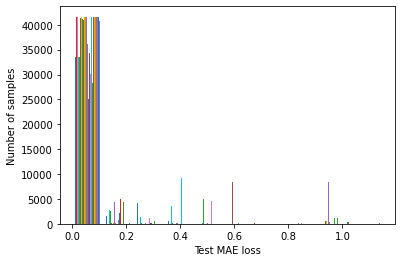

In [71]:
X_test_pred = new_model.predict(X_test, verbose=0)
test_mae_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)

plt.hist(test_mae_loss)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples');
threshold = np.max(test_mae_loss)
min_threshold=np.min(test_mae_loss)
avg=np.mean(test_mae_loss)
print(f'Reconstruction error threshold: {threshold}')
print(f'Reconstruction error threshold min: {min_threshold}')
print(f'Reconstruction error threshold avg: {avg}')


In [73]:
df=pd.read_csv('Normal_data.csv')
df.head(5)

,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,185.127.17.56-192.168.20.133-443-53648-6,185.127.17.56,443,192.168.20.133,53648,6,5/2/2020 13:58,245230,44,40,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal
1,185.127.17.56-192.168.20.133-443-53650-6,192.168.20.133,53650,185.127.17.56,443,6,5/2/2020 13:58,1605449,107,149,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal
2,192.168.20.133-192.168.20.2-35108-53-6,192.168.20.133,35108,192.168.20.2,53,6,5/2/2020 13:58,53078,5,5,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal
3,192.168.20.133-192.168.20.2-35108-53-6,192.168.20.2,53,192.168.20.133,35108,6,5/2/2020 13:58,6975,1,1,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal
4,154.59.122.74-192.168.20.133-443-60900-6,192.168.20.133,60900,154.59.122.74,443,6,5/2/2020 13:58,190141,13,16,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal


In [74]:
df.drop(['Flow ID', 'Src IP' ,'Dst IP' ,'Timestamp','Src Port','Dst Port','Protocol'], inplace=True,axis = 1)
df.shape
df = df.dropna('columns')# drop columns with NaN
pmap = {'Normal':0,'Probe ':1,'DDoS':1,'DoS':1,'BFA':1,'Web-Attack':1,'BOTNET':1,'U2R':1,'DDoS':1}
df['Label'] = df['Label'].map(pmap)

In [75]:
df['Label'].value_counts()

0    68424
Name: Label, dtype: int64

In [76]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score

In [77]:
Y = df[['Label']]
X = df.drop(['Label',], axis=1)

sc = MinMaxScaler(feature_range = (0, 1))
X = sc.fit_transform(X)

In [78]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape)
print(Y_train.shape, Y_test.shape)Y = df[['Label']]
X = df.drop(['Label',], axis=1)

sc = MinMaxScaler(feature_range = (0, 1))
X = sc.fit_transform(X)

(47896, 76) (20528, 76)
(47896, 1) (20528, 1)


In [79]:
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Test data shape:", X_test.shape)

Training data shape: (47896, 1, 76)
Test data shape: (20528, 1, 76)


Reconstruction error threshold: 1.0085564585108506
Reconstruction error threshold min: 1.4906480301808762e-06
Reconstruction error threshold avg: 0.003283416367930424


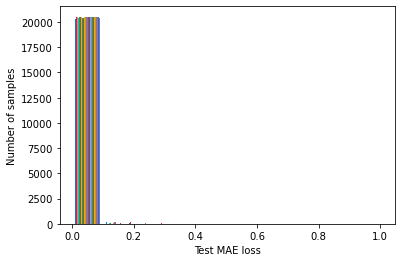

In [80]:
X_test_pred = new_model.predict(X_test, verbose=0)
test_mae_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)

plt.hist(test_mae_loss)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples');
threshold = np.max(test_mae_loss)
min_threshold=np.min(test_mae_loss)
avg=np.mean(test_mae_loss)
print(f'Reconstruction error threshold: {threshold}')
print(f'Reconstruction error threshold min: {min_threshold}')
print(f'Reconstruction error threshold avg: {avg}')


In [81]:
df=pd.read_csv('metasploitable-2.csv')
df.head(5)

,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,192.168.3.130-200.175.2.130-38694-4444-6,192.168.3.130,38694,200.175.2.130,4444,6,10/1/2020 5:02,269709,4,5,...,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,U2R
1,192.168.3.130-200.175.2.130-38693-4444-6,192.168.3.130,38693,200.175.2.130,4444,6,10/1/2020 5:02,268599,2,3,...,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,U2R
2,192.168.3.130-200.175.2.130-3632-33747-6,200.175.2.130,33747,192.168.3.130,3632,6,10/1/2020 5:02,22194,5,5,...,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,U2R
3,192.168.3.130-200.175.2.130-8180-38745-6,200.175.2.130,38745,192.168.3.130,8180,6,10/1/2020 1:39,9556,4,4,...,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,BFA
4,192.168.3.130-200.175.2.130-8180-37217-6,200.175.2.130,37217,192.168.3.130,8180,6,10/1/2020 1:39,8782,4,4,...,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,BFA


In [82]:
df.drop(['Flow ID', 'Src IP' ,'Dst IP' ,'Timestamp','Src Port','Dst Port','Protocol'], inplace=True,axis = 1)
df.shape
df = df.dropna('columns')# drop columns with NaN
pmap = {'Normal':0,'Probe ':1,'DDoS':1,'DoS':1,'BFA':1,'Web-Attack':1,'BOTNET':1,'U2R':1,'DDoS':1}
df['Label'] = df['Label'].map(pmap)

In [83]:
df['Label'].value_counts()

1.0    74986
Name: Label, dtype: int64

In [84]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score

In [85]:
Y = df[['Label']]
X = df.drop(['Label',], axis=1)

sc = MinMaxScaler(feature_range = (0, 1))
X = sc.fit_transform(X)

In [86]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape)
print(Y_train.shape, Y_test.shape)

(95720, 76) (41023, 76)
(95720, 1) (41023, 1)


In [87]:
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Test data shape:", X_test.shape)

Training data shape: (95720, 1, 76)
Test data shape: (41023, 1, 76)


Reconstruction error threshold: 1.0603631027042866
Reconstruction error threshold min: 5.1884579940968636e-06
Reconstruction error threshold avg: 0.02780898228150494


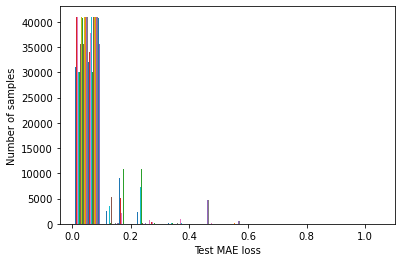

In [88]:
X_test_pred = new_model.predict(X_test, verbose=0)
test_mae_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)

plt.hist(test_mae_loss)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples');
threshold = np.max(test_mae_loss)
min_threshold=np.min(test_mae_loss)
avg=np.mean(test_mae_loss)
print(f'Reconstruction error threshold: {threshold}')
print(f'Reconstruction error threshold min: {min_threshold}')
print(f'Reconstruction error threshold avg: {avg}')


In [32]:
error_df = pd.DataFrame(train_mae_loss)

In [33]:
error_df.head()

,0,1,2,3,4,5,6,7,8,9,...,66,67,68,69,70,71,72,73,74,75
0,0.013556,0.000153,0.000240,0.000117,0.000323,0.003209,0.008528,0.006416,0.002057,0.007151,...,0.000228,0.000166,0.000867,0.000729,0.001694,0.000505,0.000977,0.003105,0.001593,0.001930
1,0.006448,0.002147,0.002298,0.000151,0.002084,0.000850,0.001495,0.000722,0.001659,0.006699,...,0.000315,0.000985,0.005543,0.002199,0.001912,0.003393,0.004560,0.002028,0.008076,0.004081
2,0.095042,0.000301,0.000256,0.000793,0.000234,0.002711,0.010025,0.009925,0.003491,0.007043,...,0.001850,0.000513,0.007718,0.001775,0.009938,0.006974,0.034227,0.009349,0.042402,0.031944
3,0.089064,0.000480,0.000170,0.000709,0.000175,0.004053,0.009143,0.006459,0.004429,0.009313,...,0.001813,0.000470,0.006514,0.001455,0.008285,0.006166,0.032503,0.008691,0.040121,0.030622
4,0.004192,0.001034,0.000959,0.000158,0.000406,0.000419,0.001013,0.000245,0.000637,0.000507,...,0.000571,0.000305,0.001886,0.002599,0.002818,0.000471,0.002749,0.001134,0.001506,0.003100


In [34]:
print(Y_test)

        Label
69892     1.0
166301    0.0
260849    1.0
306912    1.0
145052    0.0
...       ...
153469    0.0
119098    NaN
208179    NaN
282420    1.0
77683     NaN

[103167 rows x 1 columns]


In [35]:
error_df['True_Class']= Y_test

In [36]:
error_df.head()

,0,1,2,3,4,5,6,7,8,9,...,67,68,69,70,71,72,73,74,75,True_Class
0,0.013556,0.000153,0.000240,0.000117,0.000323,0.003209,0.008528,0.006416,0.002057,0.007151,...,0.000166,0.000867,0.000729,0.001694,0.000505,0.000977,0.003105,0.001593,0.001930,1.0
1,0.006448,0.002147,0.002298,0.000151,0.002084,0.000850,0.001495,0.000722,0.001659,0.006699,...,0.000985,0.005543,0.002199,0.001912,0.003393,0.004560,0.002028,0.008076,0.004081,NaN
2,0.095042,0.000301,0.000256,0.000793,0.000234,0.002711,0.010025,0.009925,0.003491,0.007043,...,0.000513,0.007718,0.001775,0.009938,0.006974,0.034227,0.009349,0.042402,0.031944,1.0
3,0.089064,0.000480,0.000170,0.000709,0.000175,0.004053,0.009143,0.006459,0.004429,0.009313,...,0.000470,0.006514,0.001455,0.008285,0.006166,0.032503,0.008691,0.040121,0.030622,NaN
4,0.004192,0.001034,0.000959,0.000158,0.000406,0.000419,0.001013,0.000245,0.000637,0.000507,...,0.000305,0.001886,0.002599,0.002818,0.000471,0.002749,0.001134,0.001506,0.003100,NaN


In [37]:
error_df = error_df.dropna('columns')

In [70]:

# precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
# plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
# plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
# plt.title('Precision and recall for different threshold values')
# plt.xlabel('Threshold')
# plt.ylabel('Precision/Recall')
# plt.legend()
# plt.show()

In [42]:
error_df = pd.DataFrame({'Reconstruction_error': [train_mae_loss],
                        'True_class': [Y_test]})

In [45]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
